# Question 1
## Part (a)

Epoch 1/20: 100%|██████████| 1000/1000 [00:10<00:00, 94.39it/s, loss=0.977]


Iteration 0, average loss = 0.9769071969985962


Epoch 2/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.12it/s, loss=0.95] 


Iteration 1, average loss = 0.9498422320485115


Epoch 3/20: 100%|██████████| 1000/1000 [00:11<00:00, 86.42it/s, loss=0.936]


Iteration 2, average loss = 0.9361025959849357


Epoch 4/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.83it/s, loss=0.928]


Iteration 3, average loss = 0.9275525305867195


Epoch 5/20: 100%|██████████| 1000/1000 [00:11<00:00, 89.88it/s, loss=0.922]


Iteration 4, average loss = 0.9216150171160697


Epoch 6/20: 100%|██████████| 1000/1000 [00:11<00:00, 87.00it/s, loss=0.917]


Iteration 5, average loss = 0.9172104735970497


Epoch 7/20: 100%|██████████| 1000/1000 [00:11<00:00, 87.34it/s, loss=0.914]


Iteration 6, average loss = 0.9137977880835533


Epoch 8/20: 100%|██████████| 1000/1000 [00:11<00:00, 87.12it/s, loss=0.911]


Iteration 7, average loss = 0.9110700042247772


Epoch 9/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.07it/s, loss=0.909]


Iteration 8, average loss = 0.9088417227864265


Epoch 10/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.70it/s, loss=0.907]


Iteration 9, average loss = 0.9069891161918641


Epoch 11/20: 100%|██████████| 1000/1000 [00:11<00:00, 87.45it/s, loss=0.905]


Iteration 10, average loss = 0.9054287513494491


Epoch 12/20: 100%|██████████| 1000/1000 [00:11<00:00, 87.40it/s, loss=0.904]


Iteration 11, average loss = 0.9041010414361954


Epoch 13/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.43it/s, loss=0.903] 


Iteration 12, average loss = 0.9029623381495476


Epoch 14/20: 100%|██████████| 1000/1000 [00:11<00:00, 87.82it/s, loss=0.902]


Iteration 13, average loss = 0.9019788796901703


Epoch 15/20: 100%|██████████| 1000/1000 [00:11<00:00, 89.49it/s, loss=0.901]


Iteration 14, average loss = 0.9011247086524964


Epoch 16/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.63it/s, loss=0.9]  


Iteration 15, average loss = 0.9003795914053917


Epoch 17/20: 100%|██████████| 1000/1000 [00:11<00:00, 85.03it/s, loss=0.9]  


Iteration 16, average loss = 0.8997267247438431


Epoch 18/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.52it/s, loss=0.899]


Iteration 17, average loss = 0.8991532143354416


Epoch 19/20: 100%|██████████| 1000/1000 [00:11<00:00, 88.78it/s, loss=0.899]


Iteration 18, average loss = 0.8986476767063141


Epoch 20/20: 100%|██████████| 1000/1000 [00:11<00:00, 90.16it/s, loss=0.898]


Iteration 19, average loss = 0.8982009989619255


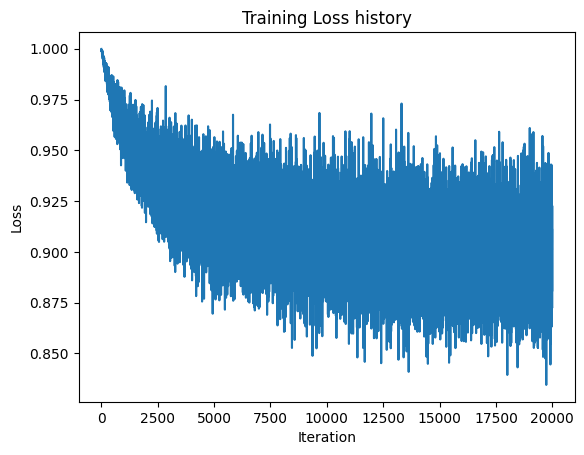

Training accuracy = 32.242
Test accuracy = 32.42


In [26]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Dataloading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define network parameters

Din = 3*32*32 #Input size (flattened image)
K = 10
std = 1e-5

#Initialize weights and biases

w = torch.randn(Din, K, dtype=torch.float32)*std
b = torch.zeros(K)

#Hyperparameters
iterations = 20
learning_rate = 2e-6
learning_rate_decay = 0.9
reg = 0
loss_history = []

# 3. Training
for t in range(iterations):
    running_loss = 0.0
    # Add tqdm progress bar
    with tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {t+1}/{iterations}") as pbar:
        for i, data in pbar:
            inputs, labels = data
            Ntr = inputs.shape[0]
            x_train = inputs.view(Ntr, -1)
            y_train_onehot = nn.functional.one_hot(labels, K).float()

            # Forward pass
            y_pred = x_train.mm(w) + b

            # Compute loss
            loss = (1/Ntr)*torch.sum((y_pred - y_train_onehot)**2) + reg*(torch.sum(w**2) + torch.sum(b**2))
            loss_history.append(loss.item())
            running_loss += loss.item()

            # Backpropagation
            dy_pred = 2.0/Ntr * (y_pred - y_train_onehot)
            dw = x_train.t().mm(dy_pred) + reg * w
            db = dy_pred.sum(dim=0) + reg * b

            # Update weights
            w -= learning_rate * dw
            b -= learning_rate * db

            # Update the progress bar description with the current loss
            pbar.set_postfix(loss=running_loss/(i+1))

    # Decay learning rate
    learning_rate *= learning_rate_decay

    # Print loss for every epoch
    print(f"Iteration {t}, average loss = {running_loss/len(trainloader)}")
# 4. Plot loss
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss history')
plt.show()

# 5. Calculate Accuracy on training set
correct_train = 0
total_train = 0

with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()

        y_pred = x_train.mm(w) + b
        _, predicted = torch.max(y_pred, 1)
        _, actual = torch.max(y_train_onehot, 1)
        total_train += labels.size(0)
        correct_train += (predicted == actual).sum().item()

train_accuracy = 100 * correct_train / total_train
print(f"Training accuracy = {train_accuracy}")

# 6. Calculate Accuracy on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        y_test_onehot = nn.functional.one_hot(labels, K).float()

        y_pred = x_test.mm(w) + b
        _, predicted = torch.max(y_pred, 1)
        _, actual = torch.max(y_test_onehot, 1)
        total_test += labels.size(0)
        correct_test += (predicted == actual).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test accuracy = {test_accuracy}")
    

##### First, the given code was run, and the results above show that the accuracy was a bit low, while the loss was moderately converging. Next, a hidden layer with 100 nodes and a sigmoid activation function was added with the given learning rate. However, the loss didn’t converge to a smaller value, so a higher standard deviation for the initialized weights was used, which also caused a rise in the loss.

Epoch 1/20: 100%|██████████| 1000/1000 [00:13<00:00, 74.83it/s, loss=0.99]


Iteration 0, average loss = 0.9902435464262962


Epoch 2/20: 100%|██████████| 1000/1000 [00:12<00:00, 79.89it/s, loss=0.974]


Iteration 1, average loss = 0.9740359754562378


Epoch 3/20: 100%|██████████| 1000/1000 [00:13<00:00, 76.77it/s, loss=0.962]


Iteration 2, average loss = 0.9619554969668388


Epoch 4/20: 100%|██████████| 1000/1000 [00:12<00:00, 81.04it/s, loss=0.953]


Iteration 3, average loss = 0.9527792816758156


Epoch 5/20: 100%|██████████| 1000/1000 [00:12<00:00, 77.15it/s, loss=0.946]


Iteration 4, average loss = 0.9456896049380302


Epoch 6/20: 100%|██████████| 1000/1000 [00:10<00:00, 98.80it/s, loss=0.94] 


Iteration 5, average loss = 0.940127433180809


Epoch 7/20: 100%|██████████| 1000/1000 [00:10<00:00, 98.00it/s, loss=0.936]


Iteration 6, average loss = 0.9357033469676972


Epoch 8/20: 100%|██████████| 1000/1000 [00:10<00:00, 97.40it/s, loss=0.932]


Iteration 7, average loss = 0.9321405701041222


Epoch 9/20: 100%|██████████| 1000/1000 [00:10<00:00, 97.00it/s, loss=0.929]


Iteration 8, average loss = 0.9292392852306366


Epoch 10/20: 100%|██████████| 1000/1000 [00:15<00:00, 65.09it/s, loss=0.927]


Iteration 9, average loss = 0.9268529137372971


Epoch 11/20: 100%|██████████| 1000/1000 [00:09<00:00, 100.90it/s, loss=0.925]


Iteration 10, average loss = 0.9248722941875458


Epoch 12/20: 100%|██████████| 1000/1000 [00:09<00:00, 106.56it/s, loss=0.923]


Iteration 11, average loss = 0.9232150518298149


Epoch 13/20: 100%|██████████| 1000/1000 [00:09<00:00, 107.20it/s, loss=0.922]


Iteration 12, average loss = 0.9218181888461113


Epoch 14/20: 100%|██████████| 1000/1000 [00:09<00:00, 103.81it/s, loss=0.921]


Iteration 13, average loss = 0.9206330955028534


Epoch 15/20: 100%|██████████| 1000/1000 [00:09<00:00, 102.19it/s, loss=0.92]


Iteration 14, average loss = 0.9196216742992401


Epoch 16/20: 100%|██████████| 1000/1000 [00:14<00:00, 69.55it/s, loss=0.919]


Iteration 15, average loss = 0.9187538860440254


Epoch 17/20: 100%|██████████| 1000/1000 [00:12<00:00, 77.03it/s, loss=0.918]


Iteration 16, average loss = 0.9180057668089867


Epoch 18/20: 100%|██████████| 1000/1000 [00:12<00:00, 79.38it/s, loss=0.917]


Iteration 17, average loss = 0.9173580530881882


Epoch 19/20: 100%|██████████| 1000/1000 [00:14<00:00, 70.68it/s, loss=0.917]


Iteration 18, average loss = 0.9167950665950775


Epoch 20/20: 100%|██████████| 1000/1000 [00:14<00:00, 67.32it/s, loss=0.916]


Iteration 19, average loss = 0.9163040144443512


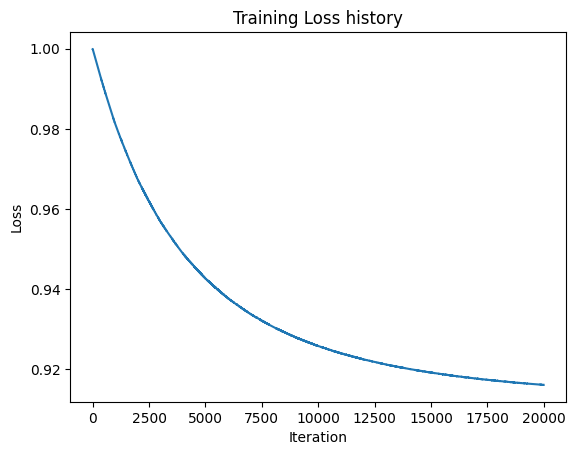

Training accuracy = 10.0
Test accuracy = 10.0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Dataloading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define network parameters

Din = 3*32*32 #Input size (flattened image)
hidden_size = 100
K = 10
std = 1e-5

#Initialize weights and biases

w1 = torch.randn(Din, hidden_size, dtype=torch.float32)*std
b1 = torch.zeros(hidden_size)
w2 = torch.randn(hidden_size, K, dtype=torch.float32)*std
b2 = torch.zeros(K)

#Hyperparameters
iterations = 20
learning_rate = 2e-6
learning_rate_decay = 0.9
reg = 0
loss_history = []

# 3. Training
for t in range(iterations):
    running_loss = 0.0
    # Add tqdm progress bar
    with tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {t+1}/{iterations}") as pbar:
        for i, data in pbar:
            inputs, labels = data
            Ntr = inputs.shape[0]
            x_train = inputs.view(Ntr, -1)
            y_train_onehot = nn.functional.one_hot(labels, K).float()

            # Forward pass
            hidden = torch.sigmoid(x_train.mm(w1) + b1)
            y_pred = hidden.mm(w2)+ b2
            

            # Compute loss
            loss = (1 / Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))

            loss_history.append(loss.item())
            running_loss += loss.item()

            # Backpropagation
            dy_pred = 2 / Ntr * (y_pred - y_train_onehot)
            dhidden = dy_pred.mm(w2.t()) * hidden * (1 - hidden)
            dw2 = hidden.t().mm(dy_pred) + reg * w2
            db2 = dy_pred.sum(dim=0)
            dw1 = x_train.t().mm(dhidden) + reg * w1
            db1 = dhidden.sum(dim=0)

            # Update weights

            w1 -= learning_rate * dw1
            b1 -= learning_rate * db1
            w2 -= learning_rate * dw2
            b2 -= learning_rate * db2

            # Update the progress bar description with the current loss
            pbar.set_postfix(loss=running_loss/(i+1))
    
    learning_rate *= learning_rate_decay
    # Print loss for every epoch
    print(f"Iteration {t}, average loss = {running_loss/len(trainloader)}")
# 4.Plot loss
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss history')
plt.show()

# 5. Calculate Accuracy on training set
correct_train = 0
total_train = 0

with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()

        hidden_train = torch.sigmoid(x_train.mm(w1) + b1)
        y_pred = hidden_train.mm(w2) + b2
        _, predicted = torch.max(y_pred, 1)
        _, actual = torch.max(y_train_onehot, 1)
        total_train += labels.size(0)
        correct_train += (predicted == actual).sum().item()

train_accuracy = 100 * correct_train / total_train
print(f"Training accuracy = {train_accuracy}")

# 6. Calculate Accuracy on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        y_test_onehot = nn.functional.one_hot(labels, K).float()

        hidden_test = torch.sigmoid(x_test.mm(w1) + b1)
        y_pred = hidden_test.mm(w2) + b2
        _, predicted = torch.max(y_pred, 1)
        _, actual = torch.max(y_test_onehot, 1)
        total_test += labels.size(0)
        correct_test += (predicted == actual).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test accuracy = {test_accuracy}")

Epoch 1/20: 100%|██████████| 1000/1000 [00:11<00:00, 90.18it/s, loss=0.878]


Iteration 0, average loss = 0.8782415391802788


Epoch 2/20: 100%|██████████| 1000/1000 [00:12<00:00, 77.75it/s, loss=0.841]


Iteration 1, average loss = 0.8406089187860489


Epoch 3/20: 100%|██████████| 1000/1000 [00:14<00:00, 66.76it/s, loss=0.827]


Iteration 2, average loss = 0.827060419678688


Epoch 4/20: 100%|██████████| 1000/1000 [00:12<00:00, 77.31it/s, loss=0.817]


Iteration 3, average loss = 0.8167552015781403


Epoch 5/20: 100%|██████████| 1000/1000 [00:13<00:00, 73.56it/s, loss=0.81]


Iteration 4, average loss = 0.8099474446773529


Epoch 6/20: 100%|██████████| 1000/1000 [00:12<00:00, 79.08it/s, loss=0.805]


Iteration 5, average loss = 0.8046502639651298


Epoch 7/20: 100%|██████████| 1000/1000 [00:12<00:00, 81.68it/s, loss=0.8] 


Iteration 6, average loss = 0.7999862617850304


Epoch 8/20: 100%|██████████| 1000/1000 [00:18<00:00, 55.01it/s, loss=0.796]


Iteration 7, average loss = 0.7963541358113289


Epoch 9/20: 100%|██████████| 1000/1000 [00:12<00:00, 79.97it/s, loss=0.793]


Iteration 8, average loss = 0.7934528771042824


Epoch 10/20: 100%|██████████| 1000/1000 [00:12<00:00, 82.97it/s, loss=0.791]


Iteration 9, average loss = 0.7911022289395332


Epoch 11/20: 100%|██████████| 1000/1000 [00:13<00:00, 74.31it/s, loss=0.789]


Iteration 10, average loss = 0.7890921426415444


Epoch 12/20: 100%|██████████| 1000/1000 [00:11<00:00, 83.51it/s, loss=0.787]


Iteration 11, average loss = 0.7873369652032852


Epoch 13/20: 100%|██████████| 1000/1000 [00:12<00:00, 79.30it/s, loss=0.786]


Iteration 12, average loss = 0.785865268588066


Epoch 14/20: 100%|██████████| 1000/1000 [00:14<00:00, 68.72it/s, loss=0.785]


Iteration 13, average loss = 0.7845503951907158


Epoch 15/20: 100%|██████████| 1000/1000 [00:14<00:00, 69.75it/s, loss=0.783]


Iteration 14, average loss = 0.7834393994212151


Epoch 16/20: 100%|██████████| 1000/1000 [00:13<00:00, 73.35it/s, loss=0.782]


Iteration 15, average loss = 0.7824032400846481


Epoch 17/20: 100%|██████████| 1000/1000 [00:12<00:00, 82.39it/s, loss=0.782]


Iteration 16, average loss = 0.7815149062275887


Epoch 18/20: 100%|██████████| 1000/1000 [00:14<00:00, 67.52it/s, loss=0.781]


Iteration 17, average loss = 0.7806925722360611


Epoch 19/20: 100%|██████████| 1000/1000 [00:12<00:00, 76.96it/s, loss=0.78]


Iteration 18, average loss = 0.7800321883559227


Epoch 20/20: 100%|██████████| 1000/1000 [00:14<00:00, 69.09it/s, loss=0.779]


Iteration 19, average loss = 0.7793462055325509


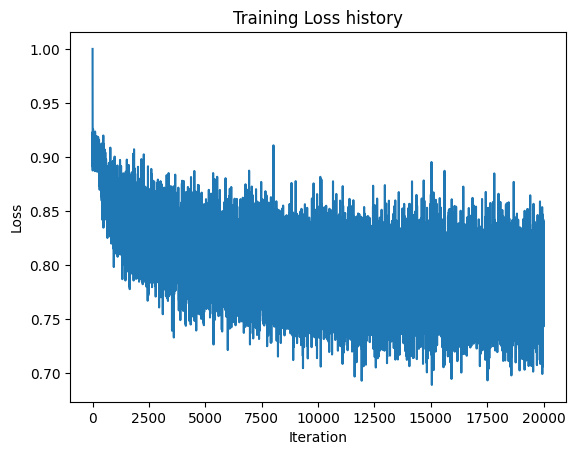

Training accuracy = 41.14
Test accuracy = 40.33


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Dataloading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define network parameters

Din = 3*32*32 #Input size (flattened image)
hidden_size = 100
K = 10
std = 1e-3

#Initialize weights and biases

w1 = torch.randn(Din, hidden_size, dtype=torch.float32)*std
b1 = torch.zeros(hidden_size)
w2 = torch.randn(hidden_size, K, dtype=torch.float32)*std
b2 = torch.zeros(K)

#Hyperparameters
iterations = 20
learning_rate = 1e-2
learning_rate_decay = 0.9
reg = 0
loss_history = []

# 3. Training
for t in range(iterations):
    running_loss = 0.0
    # Add tqdm progress bar
    with tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {t+1}/{iterations}") as pbar:
        for i, data in pbar:
            inputs, labels = data
            Ntr = inputs.shape[0]
            x_train = inputs.view(Ntr, -1)
            y_train_onehot = nn.functional.one_hot(labels, K).float()

            # Forward pass
            hidden = torch.sigmoid(x_train.mm(w1) + b1)
            y_pred = hidden.mm(w2)+ b2
            

            # Compute loss
            loss = (1 / Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))

            loss_history.append(loss.item())
            running_loss += loss.item()

            # Backpropagation
            dy_pred = 2 / Ntr * (y_pred - y_train_onehot)
            dhidden = dy_pred.mm(w2.t()) * hidden * (1 - hidden)
            dw2 = hidden.t().mm(dy_pred) + reg * w2
            db2 = dy_pred.sum(dim=0)
            dw1 = x_train.t().mm(dhidden) + reg * w1
            db1 = dhidden.sum(dim=0)

            # Update weights

            w1 -= learning_rate * dw1
            b1 -= learning_rate * db1
            w2 -= learning_rate * dw2
            b2 -= learning_rate * db2

            # Update the progress bar description with the current loss
            pbar.set_postfix(loss=running_loss/(i+1))
    
    learning_rate *= learning_rate_decay
    # Print loss for every epoch
    print(f"Iteration {t}, average loss = {running_loss/len(trainloader)}")
# 4.Plot loss
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss history')
plt.show()

# 5. Calculate Accuracy on training set
correct_train = 0
total_train = 0

with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()

        hidden_train = torch.sigmoid(x_train.mm(w1) + b1)
        y_pred = hidden_train.mm(w2) + b2
        _, predicted = torch.max(y_pred, 1)
        _, actual = torch.max(y_train_onehot, 1)
        total_train += labels.size(0)
        correct_train += (predicted == actual).sum().item()

train_accuracy = 100 * correct_train / total_train
print(f"Training accuracy = {train_accuracy}")

# 6. Calculate Accuracy on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        y_test_onehot = nn.functional.one_hot(labels, K).float()

        hidden_test = torch.sigmoid(x_test.mm(w1) + b1)
        y_pred = hidden_test.mm(w2) + b2
        _, predicted = torch.max(y_pred, 1)
        _, actual = torch.max(y_test_onehot, 1)
        total_test += labels.size(0)
        correct_test += (predicted == actual).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test accuracy = {test_accuracy}")

##### The previous parameters, like the time delay and learning rate, didn’t yield good accuracy after adding another layer to the network. So, I adjusted these parameters and retrained the model, which resulted in a slight improvement in accuracy

# Question 2

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.tanh(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Training and test configurations
batch_size = 64
learning_rate = 0.001
epochs = 10

# Data loading and transformations
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [21]:

# Lists to store train and test accuracies
train_accuracies = []
test_accuracies = []

# Training the model with a progress bar
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            pbar.update(1)

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Evaluate on the test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/10: 100%|██████████| 938/938 [00:19<00:00, 47.18batch/s]


Train Loss: 0.2992, Train Accuracy: 90.99%
Test Loss: 0.1115, Test Accuracy: 96.41%


Epoch 2/10: 100%|██████████| 938/938 [00:21<00:00, 42.67batch/s]


Train Loss: 0.0948, Train Accuracy: 97.06%
Test Loss: 0.0801, Test Accuracy: 97.46%


Epoch 3/10: 100%|██████████| 938/938 [00:23<00:00, 39.71batch/s]


Train Loss: 0.0656, Train Accuracy: 97.94%
Test Loss: 0.0597, Test Accuracy: 98.00%


Epoch 4/10: 100%|██████████| 938/938 [00:27<00:00, 33.67batch/s]


Train Loss: 0.0493, Train Accuracy: 98.43%
Test Loss: 0.0558, Test Accuracy: 98.21%


Epoch 5/10: 100%|██████████| 938/938 [00:25<00:00, 36.90batch/s]


Train Loss: 0.0396, Train Accuracy: 98.78%
Test Loss: 0.0473, Test Accuracy: 98.51%


Epoch 6/10: 100%|██████████| 938/938 [00:24<00:00, 39.02batch/s]


Train Loss: 0.0344, Train Accuracy: 98.90%
Test Loss: 0.0536, Test Accuracy: 98.28%


Epoch 7/10: 100%|██████████| 938/938 [00:24<00:00, 37.61batch/s]


Train Loss: 0.0273, Train Accuracy: 99.12%
Test Loss: 0.0448, Test Accuracy: 98.61%


Epoch 8/10: 100%|██████████| 938/938 [00:25<00:00, 37.08batch/s]


Train Loss: 0.0252, Train Accuracy: 99.16%
Test Loss: 0.0560, Test Accuracy: 98.38%


Epoch 9/10: 100%|██████████| 938/938 [00:23<00:00, 39.28batch/s]


Train Loss: 0.0218, Train Accuracy: 99.30%
Test Loss: 0.0438, Test Accuracy: 98.70%


Epoch 10/10: 100%|██████████| 938/938 [00:24<00:00, 37.61batch/s]


Train Loss: 0.0161, Train Accuracy: 99.47%
Test Loss: 0.0547, Test Accuracy: 98.48%


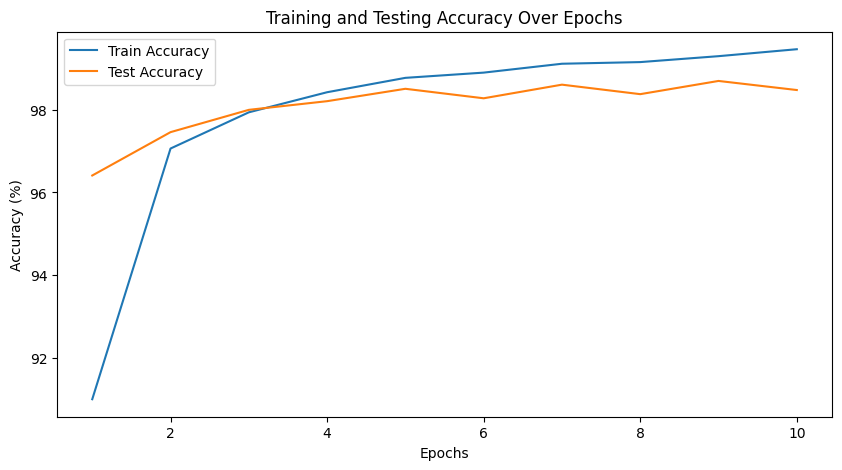

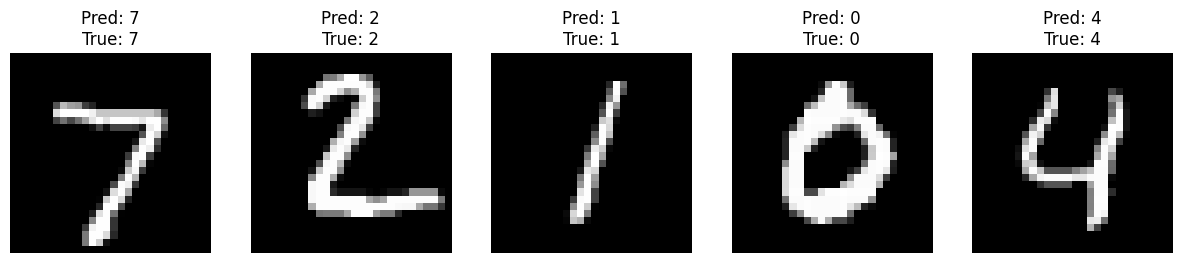

In [22]:
# Plotting train and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.show()

# Plotting a few test results
def plot_results(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        ax.axis('off')
    plt.show()

plot_results(model, test_loader)